## Problem Description
The Kaggle competition "Natural Language Processing with Disaster Tweets" is centered around classifying tweets to determine if they are about real disasters or not. The challenge requires participants to build a model that can accurately predict whether a given tweet pertains to an actual disaster (label 1) or not (label 0). This problem is a binary text classification task, which is a common application of Natural Language Processing (NLP).


## Brief Description
### Problem Description
The Kaggle competition "Natural Language Processing with Disaster Tweets" is centered around classifying tweets to determine if they are about real disasters or not. The challenge requires participants to build a model that can accurately predict whether a given tweet pertains to an actual disaster (label 1) or not (label 0). This problem is a binary text classification task, which is a common application of Natural Language Processing (NLP).

### Data Description
1. Training Data (train.csv)

Columns:
id: Unique identifier for each tweet.
keyword: Keyword from the tweet.
location: Location from where the tweet was posted.
text: The actual text of the tweet.
target: The target variable (1 if the tweet is about a real disaster, 0 otherwise).
Size and Structure:
Number of rows: 7,613
Number of columns: 5
2. Test Data (test.csv)

Columns:
id: Unique identifier for each tweet.
keyword: Keyword from the tweet.
location: Location from where the tweet was posted.
text: The actual text of the tweet.
Size and Structure:
Number of rows: 3,263
Number of columns: 4
3. Sample Submission (sample_submission.csv)

Columns:
id: Unique identifier for each tweet.
target: Placeholder column for predicted target variable (1 or 0).
Size and Structure:
Number of rows: 3,263 (same as the test data)
Number of columns: 2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

## Exploratory Data Analysis (EDA)

## Data Cleaning Procedures
Based on the initial EDA, the following data cleaning steps are proposed:

### Handling Missing Values:
Check for missing values in keyword and location columns.
Decide on a strategy for handling missing values (e.g., imputation, filling with a placeholder, or dropping).

### Text Preprocessing:
Convert text to lowercase.
Remove punctuation, special characters, and numbers.
Tokenization: Splitting the text into individual words.
Removing stopwords: Common words that do not carry significant meaning.
Lemmatization/Stemming: Reducing words to their root forms.
## Plan of Analysis
### Data Cleaning and Preprocessing:
Clean and preprocess the text data using the steps mentioned above.
Handle missing values appropriately.

### Feature Engineering:
Create additional features, such as tweet length, presence of specific keywords, and sentiment analysis scores.

### Model Selection:
Experiment with different machine learning models for text classification, such as Logistic Regression, Naive Bayes, and Support Vector Machines.
Use NLP-specific models like TF-IDF Vectorizer, Word2Vec, or more advanced models like BERT.
### Model Training and Evaluation:
Split the training data into training and validation sets.
Train the selected models and evaluate their performance using metrics like accuracy, precision, recall, and F1-score.
Fine-tune hyperparameters to improve model performance.
### Prediction and Submission:
Use the best-performing model to make predictions on the test data.
Prepare the submission file in the required format.

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [4]:
print(train.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


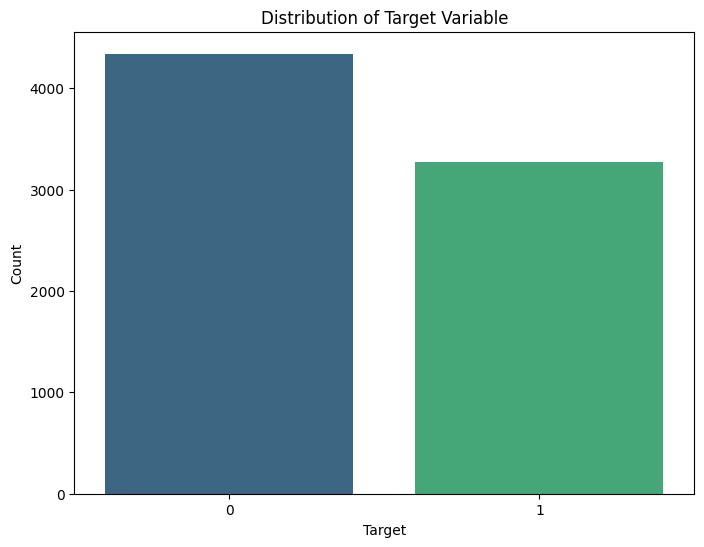

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train, palette='viridis')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


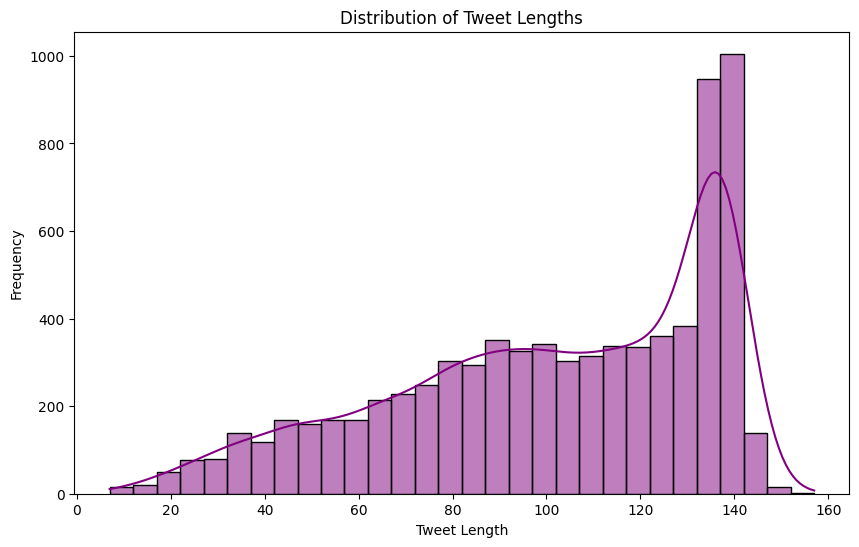

In [6]:
train['text_length'] = train['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], kde=True, color='purple', bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Visualize top 20 most frequent words in the tweets (excluding stop words)
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

vectorizer = CountVectorizer(stop_words='english')
word_count_vector = vectorizer.fit_transform(train['text'])
word_counts = word_count_vector.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()

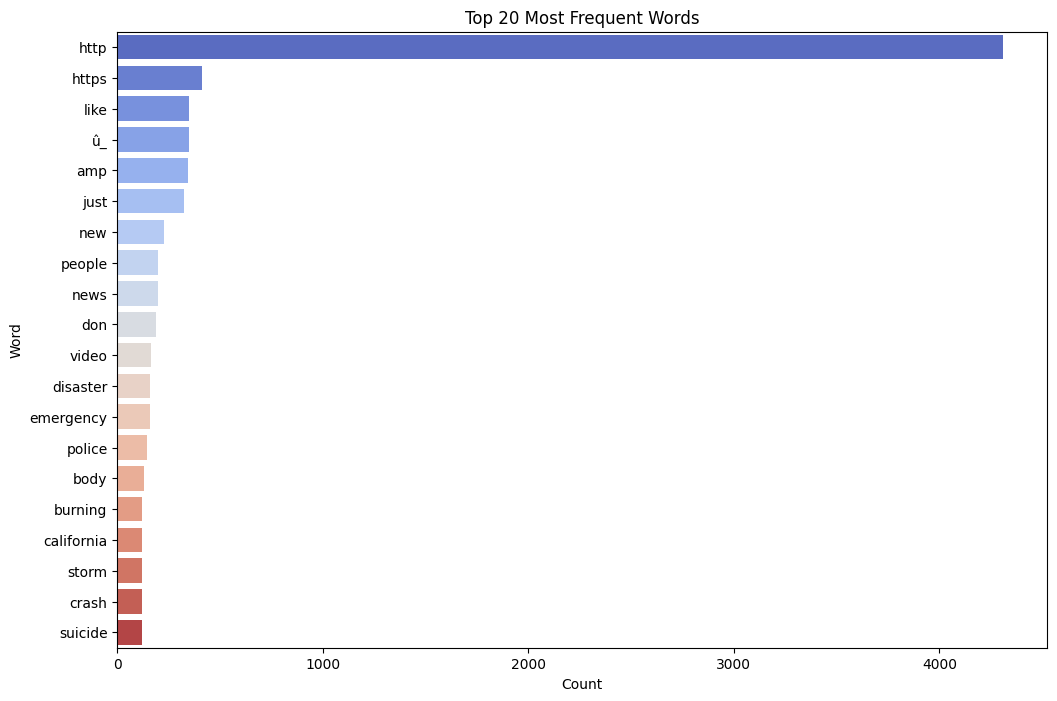

In [8]:
common_words_df = pd.DataFrame(sorted(list(zip(vocab, word_counts)), key=lambda x: x[1], reverse=True)[:20], 
                               columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='coolwarm')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

## Model Architecture and Reasoning
### Model Selection: Recurrent Neural Network (RNN)
For this text classification problem, I have chosen to use a Recurrent Neural Network (RNN) with an advanced architecture like Long Short-Term Memory (LSTM). Here’s the reasoning behind this choice:

### Sequence Modeling: 
RNNs are specifically designed to handle sequential data, which makes them suitable for text processing tasks where the order of words is important.
### Handling Long Dependencies: 
LSTMs are capable of learning long-term dependencies in sequences. This is crucial for text classification tasks, as the meaning of a tweet may depend on words that are far apart.
### Context Preservation: 
Unlike traditional models, LSTMs can maintain context over longer sequences, which helps in understanding the overall sentiment or intent in tweets.
### Bidirectional Processing: 
Using a Bidirectional LSTM allows the model to process the text in both forward and backward directions, which can lead to better understanding and improved performance.
### Text Processing and Word Embedding

### TF-IDF (Term Frequency-Inverse Document Frequency)
TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It combines two metrics:

### Term Frequency (TF): 
The frequency of a word in a document.
### Inverse Document Frequency (IDF): 
The inverse of the number of documents containing the word, which helps in reducing the weight of commonly used words.
TF-IDF works by multiplying the TF and IDF values for each word, giving higher scores to words that are frequent in a document but rare across the corpus.

In [9]:
def preprocess(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
    text = re.sub(r'\n', '', text) # Remove newline characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

train['text'] = train['text'].apply(preprocess)
test['text'] = test['text'].apply(preprocess)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)

In [11]:
tfidf = TfidfVectorizer(max_features=15000, stop_words=stopwords.words('english'))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(test['text'])

In [12]:
svc = SVC()
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_val_tfidf)

In [13]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_val_tfidf)

In [14]:
models = {
    'Support Vector Classifier': svc,
    'XGBoost': xgb
}

# Initialize variables to store the best model and accuracy
best_model = None
best_accuracy = 0

# Evaluate each model and store the one with the best accuracy
for name, model in models.items():
    predictions = model.predict(X_val_tfidf)
    accuracy = accuracy_score(y_val, predictions)
    print(f'{name} Accuracy: {accuracy}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f'\nBest Model: {best_model} with Accuracy: {best_accuracy}')

# Make predictions on the test data using the best model
test_predictions = best_model.predict(X_test_tfidf)

Support Vector Classifier Accuracy: 0.7944845699277742
XGBoost Accuracy: 0.7760998030203545

Best Model: SVC() with Accuracy: 0.7944845699277742


In [15]:
# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)